<a href="https://colab.research.google.com/github/IMVIKRANTH/Driver_drowsiness_detection/blob/main/Driver_drowiness_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import standard libraries
# 📦 Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import kagglehub


# Sklearn for preprocessing and evaluation
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# TensorFlow & Keras - Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
dataset_path  = kagglehub.dataset_download("dheerajperumandla/drowsiness-dataset")
train_dir = os.path.join(dataset_path, 'train')


### 🔍 Get Class Labels

Each class in the dataset is a folder in the `train` directory inside the dataset. Let's list the folder names.

In [4]:
# Build path to the 'train' folder inside the downloaded dataset
train_path = os.path.join(dataset_path, "train")

# List the class labels — each folder is a class (e.g., Closed, Open, yawn, no_yawn)
labels = os.listdir(train_path)
labels = sorted(labels)
print("Class labels found:", labels)


Class labels found: ['Closed', 'Open', 'no_yawn', 'yawn']


## 🖼️ Step 3: Visualize Random Images From Each Class

We'll randomly sample one image from each of the class labels to get a sense of our dataset.


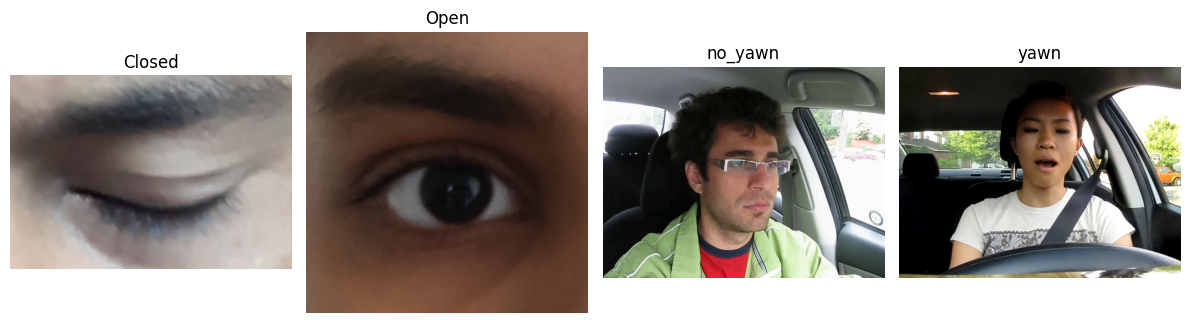

In [5]:
def show_sample_images(train_dir, labels):
    """Displays one random image from each class label."""
    plt.figure(figsize=(12, 6))
    for i, label in enumerate(labels):
        class_dir = os.path.join(train_dir, label)
        image_file = random.choice(os.listdir(class_dir))
        img_path = os.path.join(class_dir, image_file)

        # Read and display image
        img = imread(img_path)
        plt.subplot(1, len(labels), i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show samples
show_sample_images(train_path, labels)


## 🧹 Image Preprocessing

- Convert to grayscale (for efficiency, as face features dominate)
- Resize images to a fixed shape
- Normalize pixel values (0..1)

We'll load all images and associated labels into memory for this stage.


In [6]:
# Settings
IMG_SIZE = (64, 64) # Small, fast to train; you can increase for better accuracy

# Data containers
X = []
y = []

for label in labels:
    class_folder = os.path.join(train_dir, label)
    for filename in os.listdir(class_folder):
        if not filename.lower().endswith(('jpg', 'png', 'jpeg')):
            continue
        img_path = os.path.join(class_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Grayscale
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0  # Normalize
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)
print("Total images loaded:", X.shape[0])
print("Image tensor shape:", X.shape)


Total images loaded: 2900
Image tensor shape: (2900, 64, 64)


In [7]:
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)
print("Example label encoding:", y[0], "->", y_encoded[0])
print("Classes (order):", lb.classes_)


Example label encoding: Closed -> [1 0 0 0]
Classes (order): ['Closed' 'Open' 'no_yawn' 'yawn']


## 🧪 Train-Test Split

We split the data into train and test.  
Validation split will be set aside during model training.


In [8]:
X = X[..., np.newaxis]  # Add channel dimension for CNNs
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)


Train set: (2320, 64, 64, 1) Test set: (580, 64, 64, 1)


## 🧠 Simple CNN Model for Yawn/Drowsiness Detection

A basic (but effective!) convolutional neural network implemented in Keras.


In [9]:
num_classes = len(labels)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,092 (6.20 MB)

 Trainable params: 1,625,092 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Enable Mixed Precision Training for Faster, More Efficient Training (if hardware supports)
from tensorflow.keras import mixed_precision

# Set mixed precision policy (Automatically uses float16 on TensorCore GPUs)
mixed_precision.set_global_policy('mixed_float16')
print("Using mixed precision: ", mixed_precision.global_policy())


Using mixed precision:  <DTypePolicy "mixed_float16">


## 🏋️‍♀️ Train the Model

We train on our training set and validate with a held-out portion.


In [11]:
batch_size = 8  # or your preferred value

# Try to use GPU
with tf.device('/GPU:0'):
   history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=8,
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1
  )




Epoch 1/40
290/290 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.5680 - loss: 0.8762 - val_accuracy: 0.7983 - val_loss: 0.4028
Epoch 2/40
290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.7788 - loss: 0.4201 - val_accuracy: 0.8224 - val_loss: 0.3414
Epoch 3/40
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.8142 - loss: 0.3757 - val_accuracy: 0.7828 - val_loss: 0.3736
Epoch 4/40
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.8493 - loss: 0.3221 - val_accuracy: 0.8328 - val_loss: 0.3012
Epoch 5/40
 50/290 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.8626 - loss: 0.2472

KeyboardInterrupt: 

## 📊 Model Evaluation

Evaluate on the held-out test set and display a classification report.


In [12]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=lb.classes_))


Test Accuracy: 83.10%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
              precision    recall  f1-score   support

      Closed       0.95      0.99      0.97       145
        Open       0.99      0.94      0.96       145
     no_yawn       0.64      0.90      0.75       145
        yawn       0.84      0.49      0.62       145

    accuracy                           0.83       580
   macro avg       0.85      0.83      0.82       580
weighted avg       0.85      0.83      0.82       580



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


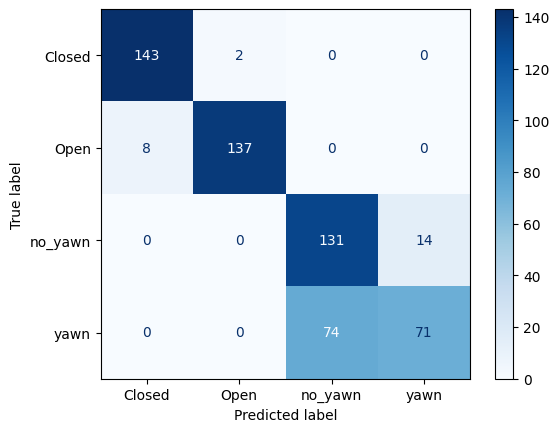

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_labels = model.predict(X_test)
pred_classes = np.argmax(pred_labels, axis=1)
true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [14]:
import matplotlib.pyplot as plt

# Extract data from history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'history' is not defined

In [15]:
print(history.history.keys())


NameError: name 'history' is not defined

In [16]:
from google.colab import files
files.download('drowsiness_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
model.save('/content/drive/My Drive/model_folder/my_model.h5')


In [17]:
prediction = model.predict(X_test)
X_test.shape

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


(580, 64, 64, 1)

In [18]:
prediction


array([[2.2677362e-01, 7.7285045e-01, 1.9797313e-04, 1.7793138e-04],
       [7.0040369e-06, 3.1151873e-07, 7.9348022e-01, 2.0651236e-01],
       [9.9532217e-01, 4.6485136e-03, 2.5058345e-05, 4.2721053e-06],
       ...,
       [5.6415106e-10, 3.6410849e-10, 5.7880965e-04, 9.9942124e-01],
       [5.9506889e-03, 9.9391717e-01, 3.6815254e-05, 9.5395473e-05],
       [8.5897758e-05, 4.8207649e-04, 7.1297848e-01, 2.8645357e-01]],
      dtype=float32)

In [30]:
from PIL import Image

IMG_SIZE = 64  # Use the size expected by your model

def prepare(filepath):
    img = Image.open(filepath).convert('L')    # 'L' mode is grayscale (1 channel)
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0          # Normalize to [0,1]
    return img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Add batch and channels axes

labels_new = ["Closed", "Open", "no_yawn", "yawn"]

In [38]:
img_filename = "no_yawn/1068.jpg"
img_path = os.path.join(train_path, img_filename)

print(img_path)  # Check that the full path is correct

# Now use this path in your custom prepare() or image loader
processed_img = prepare(img_path)
prediction = model.predict(processed_img)
predicted_label = labels_new[np.argmax(prediction)]
print("Prediction:", predicted_label)


/kaggle/input/drowsiness-dataset/train/no_yawn/1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction: no_yawn


In [34]:
img_filename = "Closed/_106.jpg"
img_path = os.path.join(train_path, img_filename)

print(img_path)  # Check that the full path is correct

# Now use this path in your custom prepare() or image loader
processed_img = prepare(img_path)
prediction = model.predict(processed_img)
predicted_label = labels_new[np.argmax(prediction)]
print("Prediction:", predicted_label)

/kaggle/input/drowsiness-dataset/train/Closed/_106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Prediction: Closed


## 📊 Model Evaluation

Evaluate on the held-out test set and display a classification report.